In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path
import numpy as np
import pytorch_lightning as pl

import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from utils.topo_ds import *
import seaborn as sns 
from utils.pershom import pers2fn
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, GradientAccumulationScheduler
from pl_modules.pl_roberta import LitRelRoberta

from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error
from utils.sim_rel import compare_topo_models
from functools import partial

from utils.export_multilingual_results import process_df
from utils.multilingual_amazon_anchors import MultilingualAmazonAnchors
from typing import *

from modules.stitching_module import StitchingModule

from datasets import load_dataset, ClassLabel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = Path("./data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = Path("./saved_models/rel_multi_topo")
CHECKPOINT_PATH_VANILLA = Path("./saved_models/rel_multi_vanilla")
RESULT_PATH = Path("./results/rel_multi_topo")
FIG_PATH =  Path("./Visualization")

PROJECT_ROOT = Path("./")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


# Data

In [3]:
fine_grained: bool = True
target_key: str = "class"
data_key: str = "content"
anchor_dataset_name: str = "amazon_translated"  
ALL_LANGS = ("en", "es", "fr")
num_anchors: int = 768
train_perc: float = 0.01

In [4]:
def get_dataset(lang: str, split: str, perc: float, fine_grained: bool):
    pl.seed_everything(42)
    assert 0 < perc <= 1
    dataset = load_dataset("amazon_reviews_multi", lang)[split]

    if not fine_grained:
        dataset = dataset.filter(lambda sample: sample["stars"] != 3)

    # Select a random subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[: int(len(indices) * perc)]
    dataset = dataset.select(indices)

    def clean_sample(sample):
        title: str = sample["review_title"].strip('"').strip(".").strip()
        body: str = sample["review_body"].strip('"').strip(".").strip()

        if body.lower().startswith(title.lower()):
            title = ""

        if len(title) > 0 and title[-1].isalpha():
            title = f"{title}."

        sample["content"] = f"{title} {body}".lstrip(".").strip()
        if fine_grained:
            sample[target_key] = str(sample["stars"] - 1)
        else:
            sample[target_key] = sample["stars"] > 3
        return sample

    dataset = dataset.map(clean_sample)
    dataset = dataset.cast_column(
        target_key,
        ClassLabel(num_classes=5 if fine_grained else 2, names=list(map(str, range(5) if fine_grained else (0, 1)))),
    )

    return dataset

def _amazon_translated_get_samples(lang: str, sample_idxs):
    anchor_dataset = MultilingualAmazonAnchors(split="train", language=lang)
    anchors = []
    for anchor_idx in sample_idxs:
        anchor = anchor_dataset[anchor_idx]
        anchor[data_key] = anchor["data"]
        anchors.append(anchor)
    return anchors

In [5]:
train_datasets = {
    lang: get_dataset(lang=lang, split="train", perc=train_perc, fine_grained=fine_grained) for lang in ALL_LANGS
    }

test_datasets = {
    lang: get_dataset(lang=lang, split="test", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

val_datasets = {
    lang: get_dataset(lang=lang, split="validation", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

num_labels = len(np.unique(train_datasets["en"][target_key], return_counts=True)[0])
print("Num labels:", num_labels)

Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-487341c777fb67da.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8bc7c81168188181.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-ff06d59b27b49158.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-148fd7c6b4cffeca.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-edf29a5fb3c71a5c.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-281ed3221a51f226.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8553f71d56c9ba4c.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-6e7cd514f6470b46.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e3dc951c42308c5b.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-620cce5b019c557c.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-b471ec6ce2ee1b83.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-32bdb5fdc88164f7.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e7ff0dc70b32da22.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-79bd585130ea3a97.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-fe159db7bc22043d.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-9714690dc0a22880.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-c271de877e412081.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-0b8801113f92f388.arrow


Num labels: 5


In [6]:
assert len(set(frozenset(train_dataset.features.keys()) for train_dataset in train_datasets.values())) == 1
class2idx = train_datasets["en"].features[target_key].str2int

train_datasets["en"].features

{'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'reviewer_id': Value(dtype='string', id=None),
 'stars': Value(dtype='int32', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_title': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'class': ClassLabel(names=['0', '1', '2', '3', '4'], id=None)}

Get pararel anchors

In [7]:
anchor_dataset2num_samples = 1000
anchor_dataset2first_anchors = [
        776,
        507,
        895,
        922,
        33,
        483,
        85,
        750,
        354,
        523,
        184,
        809,
        418,
        615,
        682,
        501,
        760,
        49,
        732,
        336,
    ]


assert num_anchors <= anchor_dataset2num_samples

pl.seed_everything(42)
anchor_idxs = list(range(anchor_dataset2num_samples))
random.shuffle(anchor_idxs)
anchor_idxs = anchor_idxs[:num_anchors]

assert anchor_idxs[:20] == anchor_dataset2first_anchors  # better safe than sorry
lang2anchors = {
    lang: _amazon_translated_get_samples(lang=lang, sample_idxs=anchor_idxs) for lang in ALL_LANGS
}

Global seed set to 42


This is how we can handdle automatically the tokenizer

In [8]:
def collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []
    
    for x, y in batch:
        data.append(x)
        if cls:
            labels.append(y)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [9]:
def multi_draw_collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []    
    for x, y in batch:
        data += x 
        if cls:
            labels += [y]*len(x)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [10]:
lang2transformer_name = {
    "en": "roberta-base",
    "es": "bertin-project/bertin-roberta-base-spanish",
    #"es": "PlanTL-GOB-ES/roberta-base-bne",
    "fr": "ClassCat/roberta-base-french",
    #"ja": "nlp-waseda/roberta-base-japanese",
}
assert set(lang2transformer_name.keys()) == set(ALL_LANGS)

In [11]:
train_lang2dataloader = {}
test_lang2dataloader = {}
val_lang2dataloader = {}
anchors_lang2dataloader = {}

for lang in ALL_LANGS:
    transformer_name = lang2transformer_name[lang]
    print(transformer_name)
    lang_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    
    aux_train_ds = DictDataset(train_datasets[lang], data_key, target_key)
    group_train_ds = IntraLabelMultiDraw(aux_train_ds, num_draws=16)
    
    train_lang2dataloader[lang] = (DataLoader(aux_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=16,
                                        drop_last=True,
                                        pin_memory=True,
                                       ),
        
                                    DataLoader(aux_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       pin_memory=True,
                                       #persistent_workers= True,
                                       batch_sampler=ClassAccumulationSampler(aux_train_ds,
                                                       batch_size=16,
                                                       drop_last=True,
                                                       accumulation=num_labels,
                                                       indv=True,
                                                       main_random=True
                                                      )
                                      ),
                                   DataLoader(group_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(multi_draw_collate_fn, tokenizer=lang_tokenizer, cls=True),
                                       batch_size=1,
                                       )
                                   
                                  )
                                  
    
    aux_test_ds = DictDataset(test_datasets[lang], data_key, target_key)
    ds_test_multi = IntraLabelMultiDraw(aux_test_ds, 16)
    test_lang2dataloader[lang] = (DataLoader(aux_test_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       pin_memory=True
                                       ),
                                  DataLoader(ds_test_multi,
                                       num_workers=4,
                                       collate_fn=partial(multi_draw_collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=1,
                                       pin_memory=True
                                       )
                                 )
    
    
    aux_val_ds = DictDataset(val_datasets[lang], data_key, target_key)
    
    
    val_lang2dataloader[lang] = DataLoader(aux_val_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       pin_memory=True
                                       )
    
    aux_anc_ds = DictDataset(lang2anchors[lang], data_key, target_key)
     
    anchors_lang2dataloader[lang] = DataLoader(aux_anc_ds,
                                       num_workers=4,
                                       pin_memory=True,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=48,
                                       )

roberta-base
bertin-project/bertin-roberta-base-spanish
ClassCat/roberta-base-french


# Analyze topo vanilla

In [12]:
def compare_topo(model, dataloader, save_path, title="", pers="L_2", plot_topo=False, relative=True):
    model.to(device)
    model.eval()
    pers_fn = pers2fn(pers)
    
    pre_topo = []
    pre_topo_max = []
    if relative:
        post_topo = []
        post_topo_max = []
        
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(dataloader, position=0, leave=True, desc="Computing"):
            batch.to(device)
            res = model(batch_idx=batch_idx, **batch)
            aux = pers_fn(res["batch_latent"].contiguous())[0][0][:, 1].tolist()
            pre_topo += aux
            pre_topo_max.append(np.max(aux))
            if relative:
                aux = pers_fn(res["norm_similarities"].contiguous())[0][0][:, 1].tolist()
                post_topo += aux
                post_topo_max.append(np.max(aux))
            
            batch_idx = 1
    
    print(f"Pre mean {np.mean(pre_topo)}. Pre max mean {np.mean(pre_topo_max)}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    if relative:
        print(f"Post mean {np.mean(post_topo)}. Post max mean {np.mean(post_topo_max)}")
        sns.kdeplot(post_topo, linewidth=2, fill=True, label="Post-rel", ax=ax1)
        
    sns.kdeplot(pre_topo, linewidth=2, fill=True, label="Pre-rel", ax=ax1)
    ax1.set_title("All death times")
    
    if relative:
        sns.kdeplot(post_topo_max, linewidth=2, fill=True, label="Post-rel", ax=ax2)
        
    sns.kdeplot(pre_topo_max, linewidth=2, fill=True, label="Pre-rel", ax=ax2)
    ax2.set_title("Max death times")

    if relative:
        plt.legend()
        
    ax1.grid()
    ax2.grid()
    fig.suptitle(title)
    plt.tight_layout()
    # fig.savefig(save_path)
    if plot_topo:
        plt.show()
    
    plt.close()

    if relative:
        return pre_topo, pre_topo_max, post_topo, post_topo_max
    else:
        return pre_topo, pre_topo_max

# Train

In [13]:
from pl_modules.pl_topo_roberta import LitTopoRelRoberta

In [14]:
def test_model(model, dataloader, title=""):
    preds = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for batch, _ in tqdm(dataloader, position=0, leave=True, desc="Computing"+title):
            batch.to(device)
            batch_latents = model(batch_idx=batch_idx, **batch)["prediction"].argmax(-1)
            preds.append(batch_latents)
            batch_idx = 1

    preds = torch.cat(preds, dim=0).detach().cpu().numpy()
    test_y = np.array(test_datasets["en"][target_key])

    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, preds, average="weighted")
    mae = mean_absolute_error(y_true=test_y, y_pred=preds)
    acc = (preds == test_y).mean()
    return precision, recall, acc, fscore, mae

In [15]:
torch.autograd.set_detect_anomaly(True)

EPOCHS = 40 if fine_grained else 3


def train_network(lang, mode="relative", seed=24, test=False, topo=None):
    
    # Create a PyTorch Lightning trainer with the generation callback
    aux = 'fine_grained' if fine_grained else 'coarse_grained'
    title = CHECKPOINT_PATH /  f"{aux}/{lang}_{mode}_seed{seed}"
    epochs_mix = 0
    epochs = EPOCHS + epochs_mix
    #acumulator = GradientAccumulationScheduler(scheduling={0: num_labels+1, epochs_mix: num_labels})
    trainer = pl.Trainer(default_root_dir=title, 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         gradient_clip_val=1,
                         accumulate_grad_batches=num_labels+1,
                         max_epochs=epochs, 
                         reload_dataloaders_every_n_epochs=1,
                         callbacks=[ModelCheckpoint(save_weights_only=True,
                                                   mode="max", monitor="val_acc"
                                                   ),
                                    ModelCheckpoint(save_weights_only=True,
                                                   ),
                                    LearningRateMonitor(logging_interval='step'),
                                    #acumulator
                                    ]
                         )
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    transformer_model = lang2transformer_name[lang]
    
    anchor_loader = None
    if mode == "relative":
        anchor_loader = anchors_lang2dataloader[lang]
    
    
    steps = epochs_mix*len(train_lang2dataloader[lang][0]) + EPOCHS*len(train_lang2dataloader[lang][1])
    power = 10*(round((2+98/48000*(len(train_datasets[lang])-2000))/10)+1)
    power = 10
    print(power)
    freq_anchors = power*(num_labels+1)
    model = LitTopoRelRoberta(
                          num_labels=num_labels,
                          transformer_model=transformer_model,
                          anchor_dataloader=anchor_loader,
                          epochs_mix=epochs_mix,
                          train_load=train_lang2dataloader[lang][0],
                          topo_load=train_lang2dataloader[lang][1],
                          topo_par=topo,
                          hidden_size=num_anchors,
                          normalization_mode="batchnorm",
                          output_normalization_mode=None,
                          dropout_prob=0.1,
                          seed=seed,
                          steps=steps,
                          weight_decay=0.01, 
                          head_lr=1e-3/(num_labels),
                          encoder_lr=1.75e-4/(num_labels),
                          layer_decay=0.65,
                          scheduler_act=True,
                          freq_anchors=freq_anchors,
                          device=device,
                          fine_tune=False,
                          in_batchsize=16
                          )
    
    val_loader = val_lang2dataloader[lang]
    trainer.fit(model, val_dataloaders=val_loader)
    
    if test:
        
        res = test_model(model.net, test_lang2dataloader[lang][0])
        with open("res.txt", "a") as f:
            f.write(f"-------------{topo}-------------\n")
            f.write(f"precision {res[0]}\n")
            f.write(f"recall {res[1]}\n")
            f.write(f"acc {res[2]}\n")
            f.write(f"fscore {res[3]}\n")
            f.write(f"mae {res[4]}\n")
            
        print("precision", res[0])
        print("recall", res[1])
        print("acc", res[2])
        print("fscore", res[3])
        print("mae", res[4])
        
        
        compare_topo(model.net, test_lang2dataloader[lang][1],
                 FIG_PATH / "rel_topo"/
                 f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{lang}_{mode}_seed{seed}.png",
                 title=f"{lang.upper()} {mode}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                 pers="L_2", plot_topo=True, relative=mode=="relative");
       
    
    model.to("cpu")
    del model
    

In [16]:
#train_network("fr", mode="absolute", seed=0, test=True, topo=None)
#train_network("fr", mode="absolute", seed=0, test=True, topo=("pre", "L_2", 9, 0.1, None))
#train_network("fr", mode="absolute", seed=0, test=True, topo=("pre", "L_2",  8, 1, None))
#train_network("fr", mode="absolute", seed=0, test=True, topo=("pre", "L_2",  7, 1, None))

#train_network("fr", mode="absolute", seed=0, test=True, topo=("pre", "L_2", 8, 0.1, "L_1"))
#train_network("en", mode="absolute", seed=0, test=True, topo=("pre", "L_2", 7, 0.1, "L_1"))
#train_network("fr", mode="absolute", seed=0, test=True, topo=("pre", "L_2", 3, 0.1, "L_2"))

In [17]:
SEEDS = [0]
run = False

if run:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for embedding_type in tqdm(["absolute"], leave=False, desc="embedding_type"):
            for train_lang in tqdm(["fr"], leave=False, desc="lang"):
                model = LitTopoRelRoberta.load_from_checkpoint(
                              CHECKPOINT_PATH / 
                              f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_lang}_{embedding_type}_seed{seed}" /
                              f"lightning_logs/version_0/checkpoints/{'epoch=4-step=120.ckpt' if fine_grained else 'epoch=2-step=3750.ckpt'}" )
                model = model.net
                is_rel = embedding_type=="relative"
                if is_rel:
                    model.anchor_dataloader = anchors_lang2dataloader[train_lang]
                    
                
                res = test_model(model, test_lang2dataloader[train_lang][0])
                with open("res.txt", "a") as f:
                    f.write(f"-------------###-------------\n")

                    f.write(f"precision {res[0]}\n")
                    f.write(f"recall {res[1]}\n")
                    f.write(f"acc {res[2]}\n")
                    f.write(f"fscore {res[3]}\n")
                    f.write(f"mae {res[4]}\n")


                print("precision", res[0])
                print("recall", res[1])
                print("acc", res[2])
                print("fscore", res[3])
                print("mae", res[4])
                
                compare_topo(model, test_lang2dataloader[train_lang][1],
                 FIG_PATH / "rel_vanilla"/
                 f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{train_lang}_{embedding_type}_seed{seed}.png",
                 title=f"{train_lang.upper()} {embedding_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                 pers="L_2", plot_topo=True, relative=is_rel);
                

In [18]:
SEEDS = [0]
TRAIN = False

if TRAIN:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for fine_tune in tqdm([False], leave=False, desc="fine_tune"):
            for embedding_type in tqdm(["relative"], leave=False, desc="embedding_type"):
                for train_lang in tqdm(ALL_LANGS, leave=False, desc="lang"):
                    train_network(train_lang, mode=embedding_type, seed=seed, fine_tune=fine_tune)
                    clear_output(wait=True)


# Results

## Compute

Global seed set to 0
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Global seed set to 0
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_hea

Pre mean model1 4.215135414404864. Pre max mean model1 9.84574171795845
Pre mean model2 3.8924189315399045. Pre max mean model2 9.803588836097717


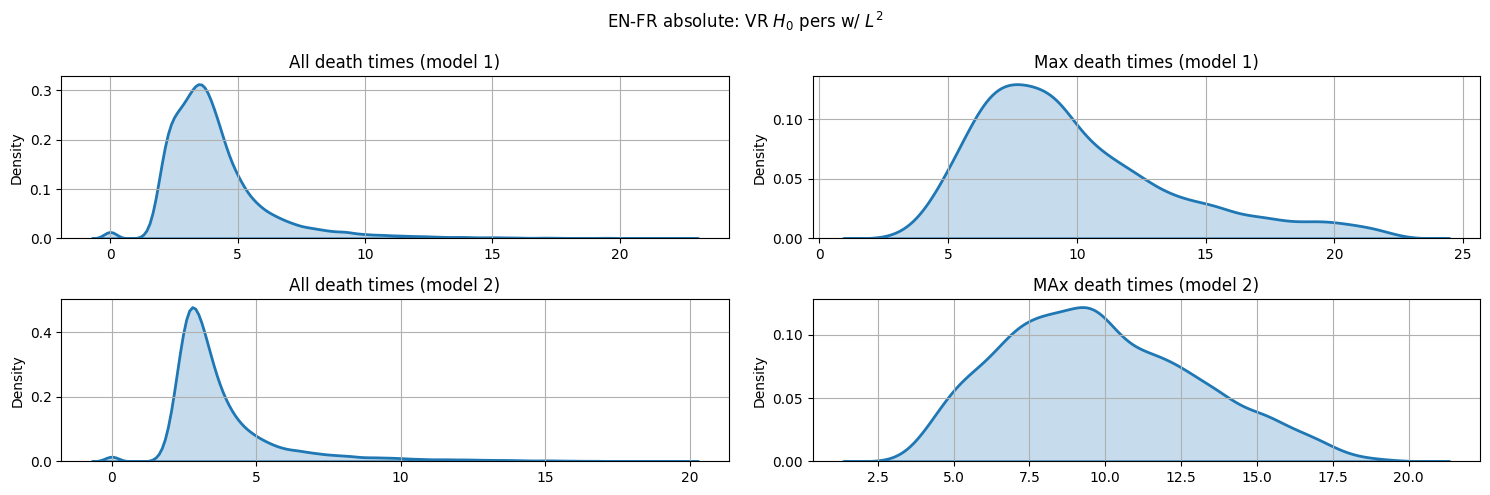

Computing seed0_absolute_fr_en: 100%|████████████████████████████████████████| 157/157 [00:12<00:00, 12.36it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Computing seed0_absolute_fr_fr: 100%|████████████████████████████████████████| 157/157 [00:12<00:00, 12.44it/s]


In [28]:
numeric_results = {
    "seed": [],
    "embed_type": [],
    "enc_lang": [],
    "dec_lang": [],
    "precision": [],
    "recall": [],
    "acc": [],
    "fscore": [],
    "mae": [],
    "stitched": [],
    "CKA_pre":[],
    "CKA_post":[],
}

pers_fn = pers2fn("L_2")

for seed in [0]:
    models = {
        
        embedding_type: {
                train_lang: LitTopoRelRoberta.load_from_checkpoint(
                                CHECKPOINT_PATH / 
                                f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_lang}_{embedding_type}_seed{seed}" /
                                f"lightning_logs/version_0/checkpoints/{'epoch=39-step=960.ckpt' if fine_grained else 'epoch=2-step=3750.ckpt'}" )

                for train_lang in ["en", "fr"]
            }
            for embedding_type in ["absolute"]
    }
    

    for embed_type in [ "absolute"]:
        for i, enc_lang  in enumerate(["en", "fr"]):
            for j, dec_lang  in enumerate(["en", "fr"]):
                
                model_enc = models[embed_type][enc_lang].net
                relative = embed_type == "relative"
                if relative:
                    model_enc.anchor_dataloader = anchors_lang2dataloader[enc_lang]
                    
                if enc_lang != dec_lang:
                    model_dec = models[embed_type][dec_lang].net
                    model = StitchingModule(model_enc, model_dec)
                else:
                    model= model_enc
                
                # The data is paired with its encoder
                test_loader = test_lang2dataloader[enc_lang][0]
                title = f" seed{seed}_{embed_type}_{enc_lang}_{dec_lang}"

                precision, recall, acc, fscore, mae = test_model(model, test_loader, title)
                if j>i:
                    if relative:
                        model_dec.anchor_dataloader = anchors_lang2dataloader[dec_lang]
                        
                    res = compare_topo_models(model_enc, model_dec, device,
                                        dataloader1=test_lang2dataloader[enc_lang][1],
                                        dataloader2=test_lang2dataloader[dec_lang][1],
                                        save_path= FIG_PATH / "rel_topo"/
                                                    f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{enc_lang}_{dec_lang}_{embed_type}_seed{seed}.png",
                                        title=f"{enc_lang.upper()}-{dec_lang.upper()} {embed_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                                        pers_fn=pers_fn,
                                        plot=True,
                                        relative=relative,
                                        )
                    if relative:
                        numeric_results["CKA_pre"].append(res[0])
                        numeric_results["CKA_post"].append(res[1])
                    else:
                        numeric_results["CKA_pre"].append(res)
                        numeric_results["CKA_post"].append(-1)
                
                else:
                    numeric_results["CKA_pre"].append(-1)
                    numeric_results["CKA_post"].append(-1)
                
                numeric_results["embed_type"].append(embed_type)
                numeric_results["enc_lang"].append(enc_lang)
                numeric_results["dec_lang"].append(dec_lang)
                numeric_results["precision"].append(precision)
                numeric_results["recall"].append(recall)
                numeric_results["acc"].append(acc)
                numeric_results["fscore"].append(fscore)
                numeric_results["stitched"].append(enc_lang != dec_lang)
                numeric_results["mae"].append(mae)
                numeric_results["seed"].append(seed)


                    


In [37]:
numeric_results["full"]

{'seed': [0, 0, 0, 0],
 'embed_type': ['relative', 'relative', 'relative', 'relative'],
 'enc_lang': ['en', 'en', 'es', 'es'],
 'dec_lang': ['en', 'es', 'en', 'es'],
 'precision': [0.45434980202856434,
  0.4549668300270889,
  0.4415922517646036,
  0.4343681921516567],
 'recall': [0.5546, 0.553, 0.5212, 0.5166],
 'acc': [0.5546, 0.553, 0.5212, 0.5166],
 'fscore': [0.4967999978930822,
  0.4958994830748917,
  0.46952292868087897,
  0.4661437923095846],
 'mae': [0.533, 0.5372, 0.5638, 0.5772],
 'stitched': [False, True, True, False]}

In [29]:
df = pd.DataFrame(numeric_results)
df
"""
df_2 = pd.read_csv(
    RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-finetune-{train_perc}.tsv",
    sep='\t')

df = pd.concat([df, df_2])
df.to_csv(
    RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
    sep="\t",
    index=False
)
"""

'\ndf_2 = pd.read_csv(\n    RESULT_PATH / f"nlp_multilingual-stitching-amazon-{\'fine_grained\' if fine_grained else \'coarse_grained\'}-finetune-{train_perc}.tsv",\n    sep=\'\t\')\n\ndf = pd.concat([df, df_2])\ndf.to_csv(\n    RESULT_PATH / f"nlp_multilingual-stitching-amazon-{\'fine_grained\' if fine_grained else \'coarse_grained\'}-{mode}-{train_perc}.tsv",\n    sep="\t",\n    index=False\n)\n'

In [30]:
df

,seed,embed_type,enc_lang,dec_lang,precision,recall,acc,fscore,mae,stitched,CKA_pre,CKA_post
0,0,absolute,en,en,0.608472,0.6068,0.6068,0.605617,0.4522,False,-1.000000,-1
1,0,absolute,en,fr,0.199531,0.3656,0.3656,0.214065,0.8650,True,0.000789,-1
2,0,absolute,fr,en,0.219331,0.2066,0.2066,0.080141,1.9594,True,-1.000000,-1
3,0,absolute,fr,fr,0.513749,0.5228,0.5228,0.515674,0.5780,False,-1.000000,-1


## View

In [ ]:
fine_grained: bool = False

df_fine, tex_fine = process_df(fine_grained=fine_grained, mode="finetune", path=RESULT_PATH)

print(tex_fine)

df_fine

In [ ]:
df_full, tex_full = process_df(fine_grained=fine_grained, mode="full", path=RESULT_PATH)

print(tex_full)
df_full